# Exploratary Data Analysis on EdX Data (2013-14)

In [1]:
import numpy as np 
import pandas as pd 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# PATH to data file
file='HMXPC13_DI_v2_5-14-14.csv'
path='/Users/suka/Downloads/dataverse_files'
filename=path+'/'+file

In [3]:
#  READ THE CSV to data frame 
full_df = pd.read_csv(filename,parse_dates=True)


In [4]:
#filter out rows which do not have data for DoB , Education, etc
#valid_rows = np.logical_and.reduce((full_df['YoB'].notnull(),full_df['gender'].notnull(),full_df['LoE_DI'].notnull()))
#df = full_df[valid_rows] # extract the rows with complete data


# Extract relevant fields 
data = full_df[['course_id','userid_DI','final_cc_cname_DI','LoE_DI','YoB','gender','start_time_DI','grade','viewed','explored','nevents','ndays_act','nplay_video','nchapters','certified','registered','incomplete_flag']].copy()

# split the course id into multiple fields
a,b,c = data['course_id'].str.split('/').str
data.insert(1,'institution',a)
data.insert(2,'course',b)

# clean up the year which has the _spring,_fall suffixes 
a = c.str.split('_').str[0]
b = c.str.split('_').str[1]

data.insert(3,'year',a)
data.insert(4,'term',b)

data.drop('course_id',axis=1,inplace=True)

# Create the mapping of course-id to title 
courselist = {'CB22x':'Greek Heros', 'CS50x':'Computer Science','ER22x':'Justice','PH207x':'Health Stat','PH278x':'Health Env','14.73x':'Poverty','2.01x':'Structures','3.091x':'SS Chemistry','6.002x':'Circuits','6.00x':'Computer Pgming','7.00x':'Biology','8.02x':'Electricity & Magnetism','8.MReV':'Mechanics'}
data['course'].replace(courselist, inplace=True)

#rename columns 
data.rename(columns={'nchapters':'chapters viewed','ndays_act':'days active','nplay_video':'videos played','course_id': 'course', 'final_cc_cname_DI': 'country','LoE_DI':'education','userid_DI':'user',"start_time_DI":"start-time"}, inplace=True)


data['YoB'] = data.groupby('course')['YoB'].transform(lambda x: x.fillna(x.median()))
data['gender'] = data.groupby('course')['gender'].transform(lambda x: x.fillna(x.value_counts().index[0]))
data['education'] = data.groupby('course')['education'].transform(lambda x: x.fillna(x.value_counts().index[0]))



In [5]:
#Fill NaN data with zeros


# change the datatypes of some of the columns
data['institution']= data.institution.astype('category')
data['course']= data.course.astype('category')

e_order = ["Less than Secondary","Secondary","Bachelor's","Master's","Doctorate"]
#e_type = pd.api.types.CategoricalDtype(categories=["Less than Secondary","Secondary","Bachelor's","Master's","Doctorate"], ordered=True)

data['grade'] = pd.to_numeric(data['grade'],errors='coerce')
data['grade'] = data['grade'].fillna(0).multiply(100)
data['education']= data.education.astype('category').cat.set_categories(e_order, ordered=True)


data['chapters viewed'].fillna(0,inplace=True) # replace NaN with 0 
data['nevents'].fillna(0,inplace=True) # replace NaN with 0 
data['videos played'].fillna(0,inplace=True) # replace NaN with 0 
data['chapters viewed'].fillna(0,inplace=True) # replace NaN with 0 
data['days active'].fillna(0,inplace=True) # replace NaN with 0 
data['term'].fillna('Fall',inplace=True)

data['gender']= data.gender.astype('category')
data['year']= data.year.astype('int')
data['YoB']= data.YoB.astype('int')
data['nevents']= data.nevents.astype('int')

data['start-time'] = pd.to_datetime(data['start-time'])

# Add a column "age" using YoB (age calculated as on 2014)
data.insert(3,"age", [(x.year-x.YoB) for index, x in data.iterrows() ])

In [6]:
aggregations = { 'registered':'sum'}
course_per_user = data['user'].value_counts() 
c_user  = data.groupby(['user'],as_index=False).agg(aggregations)

c_user.head()
multi = c_user[c_user.registered > 1]
x = multi.groupby(['registered']).count()
print(x)


             user
registered       
2           78269
3           21982
4            7171
5            2643
6             900
7             334
8             132
9              93
10             42
11             40
12             28
13             15
14             24
15             17
16             20


In [7]:

modeldata = data.copy()

encoder = LabelEncoder()
icode = encoder.fit_transform(data['institution'])
ccode = encoder.fit_transform(data['country'])
cscode = encoder.fit_transform(data['course'])
educode = encoder.fit_transform(data['education'])
gendercode=encoder.fit_transform(data['gender'])
usercode=encoder.fit_transform(data['user'])

# Eliminate the categorical data and use the encoded information 
modeldata.drop(['institution','term','start-time','course','country','education','YoB','year','gender','registered','user','incomplete_flag'],axis=1,inplace=True)

#modeldata.insert(0,"user",usercode)
modeldata.insert(1,"country",ccode)
modeldata.insert(2,"course",cscode)
modeldata.insert(3,"education",educode)
modeldata.insert(4,"gender",gendercode)
modeldata.insert(5,"institution",icode)



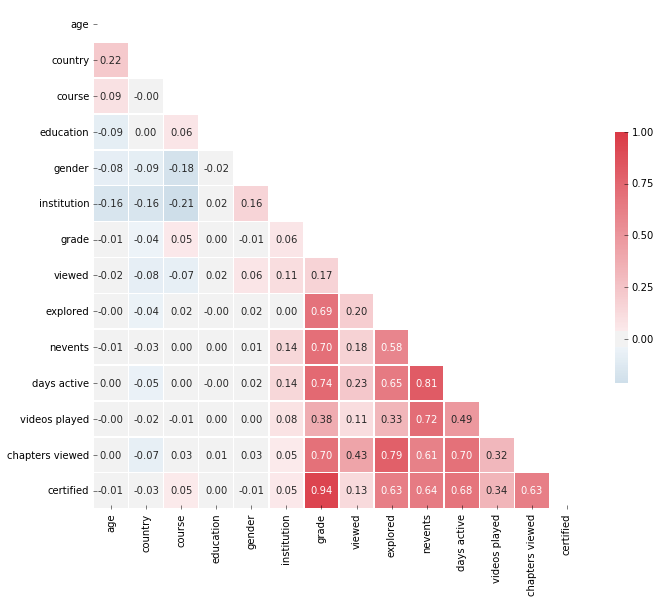

In [8]:
%matplotlib inline
corr = modeldata.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr,  mask=mask,cmap=cmap, center=0,annot=True,fmt='.2f',
             linewidths=.5, cbar_kws={"shrink": .5})

# Simple Logistic Regression Model

In [9]:
#Build the logistic regression model

modeldata.fillna(0,inplace=True) # replace NaN with 0 

X = modeldata.drop(['grade','certified'],axis = 1)
Y = modeldata['certified']

Yg = modeldata['grade']

# Split the dataset into test and training set with 30/70 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .4, random_state=42)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

    
# Predict the resukts on test data  
y_pred = LogReg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Print the metrics 
print(cm)
print(classification_report(y_test, y_pred))

# Generate table of predictions vs actual
#pd.crosstab(y_test,y_pred)


[[247965   1390]
 [  2051   5050]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    249355
          1       0.78      0.71      0.75      7101

avg / total       0.99      0.99      0.99    256456



# ROC Curve - 

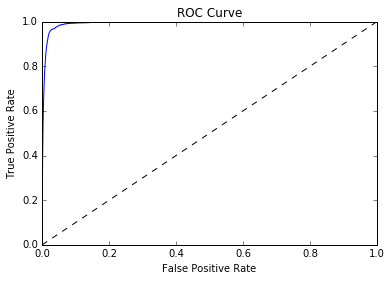

In [10]:
from sklearn.metrics import roc_curve


y_pred_prob = LogReg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## looks like ROC for class 0 (not certifed) ? how to get the ROC for class 1 ??

# Hyper parameter tuning 

In [11]:
start_time = time.time()


# Import necessary modules

from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}


# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(LogReg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train,y_train)


# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

print("run time %s seconds " % (int(time.time() - start_time)))



Tuned Logistic Regression Parameters: {'C': 1389495.494373136}
Best score is 0.9863991556662386
run time 420.24464082717896 seconds ---


### how can I use the best model/predict from hyper parameter tuning (instead of running one more instance as below)
### Different parameter values in dfferent runs ??

In [12]:
cbest = logreg_cv.best_params_['C']


LogReg = LogisticRegression(C=cbest)
LogReg.fit(X_train, y_train)

    
# Predict the resukts on test data  
y_pred = LogReg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Print the metrics 
print(cm)
print(classification_report(y_test, y_pred))



[[247967   1388]
 [  2047   5054]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    249355
          1       0.78      0.71      0.75      7101

avg / total       0.99      0.99      0.99    256456



### very little difference in confusion matrix

### parameter tuning - C & penalty 

In [ ]:

start_time = time.time()


# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


print("run time %s seconds " % (time.time() - start_time))


### This one is taking too much time 

In [13]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = LogReg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test,y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(LogReg,X,Y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9934023316277669
AUC scores computed using 5-fold cross-validation: [ 0.99244246  0.98632738  0.99445673  0.99463661  0.9954138 ]


### again the numbers seem to be for class 0 ???

In [ ]:
# Import necessary modules

from sklearn.linear_model import ElasticNet

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid,cv=5)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


### Decision Tree Model

In [26]:
start_time = time.time()


# Try the DecisionTree 

TreeReg = DecisionTreeRegressor()
TreeReg.fit(X_train, y_train)

# Predict the results on test data  
y_pred = TreeReg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


cm = confusion_matrix(y_test, y_pred)
print(cm)


print(classification_report(y_test, y_pred))


print("run time %s seconds " % (int(time.time() - start_time)))


[[247548   1807]
 [  1758   5343]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    249355
          1       0.75      0.75      0.75      7101

avg / total       0.99      0.99      0.99    256456

run time 1 seconds 


In [15]:
from sklearn.model_selection import cross_val_score
result=cross_val_score(TreeReg,X_train, y_train,scoring="neg_mean_squared_error",cv=5)
rmse_result=np.sqrt(-result)
print("Scores : ",result)

Scores :  [-0.01376451 -0.01350456 -0.01463554 -0.01347874 -0.01338775]


### Random Forest Model

In [28]:
from sklearn.ensemble import RandomForestRegressor

start_time = time.time()


ForestReg = RandomForestRegressor()
ForestReg.fit(X_train,y_train)


y_pred = ForestReg.predict(X_test)

#print(classification_report(y_test, y_pred))


fmse = mean_squared_error(y_test, y_pred)
f_rmse = np.sqrt(fmse)
print(f_rmse)


print("run time %s seconds " % (int(time.time() - start_time)))
pd.crosstab(y_test,y_pred)


0.0873242154702
run time 8 seconds 


col_0,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
certified,,,,,,,,,,,
0,244294,1558,885,613,436,384,308,273,225,201,178
1,164,170,210,246,317,388,497,657,873,1291,2288


### whats the right metric to use - 
MSE ?
Confusion Matrix
Precision , Recall 
AUC 

# Normalize the values before applying the model 

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler().fit(X_train)
minmax = MinMaxScaler().fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_mm = minmax.transform(X_train)
X_test_mm = minmax.transform(X_test)



### Use standardized values in the Logistic Regression model

In [33]:
LogReg = LogisticRegression()
LogReg.fit(X_train_std, y_train)

    
# Predict the resukts on test data  
y_pred = LogReg.predict(X_test_std)
cm = confusion_matrix(y_test, y_pred)

# Print the metrics 
print(cm)
print(classification_report(y_test, y_pred))




[[247970   1385]
 [  2044   5057]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    249355
          1       0.79      0.71      0.75      7101

avg / total       0.99      0.99      0.99    256456



### Use minmax scaled values in the Logistic Regression model

In [40]:
LogReg = LogisticRegression()
LogReg.fit(X_train_mm, y_train)

    
# Predict the resukts on test data  
y_pred = LogReg.predict(X_test_mm)
cm = confusion_matrix(y_test, y_pred)

# Print the metrics 
print(cm)
print(classification_report(y_test, y_pred))


[[247933   1422]
 [  2077   5024]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    249355
          1       0.78      0.71      0.74      7101

avg / total       0.99      0.99      0.99    256456



### Use the standardized values in DecisionTree 

In [34]:
start_time = time.time()


# Try the DecisionTree 

TreeReg = DecisionTreeRegressor()
TreeReg.fit(X_train_std, y_train)

# Predict the results on test data  
y_pred = TreeReg.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)


cm = confusion_matrix(y_test, y_pred)
print(cm)


print(classification_report(y_test, y_pred))


print("run time %s seconds " % (int(time.time() - start_time)))

[[247543   1812]
 [  1746   5355]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    249355
          1       0.75      0.75      0.75      7101

avg / total       0.99      0.99      0.99    256456

run time 1 seconds 


### Use the standardized values in RandomForest

In [36]:
start_time = time.time()


ForestReg = RandomForestRegressor()
ForestReg.fit(X_train_std,y_train)


y_pred = ForestReg.predict(X_test_std)

#print(classification_report(y_test, y_pred))


fmse = mean_squared_error(y_test, y_pred)
f_rmse = np.sqrt(fmse)
print(f_rmse)


print("run time %s seconds " % (int(time.time() - start_time)))
pd.crosstab(y_test,y_pred)

0.0874866020786
run time 7 seconds 


col_0,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
certified,,,,,,,,,,,
0,244274,1541,863,604,480,404,322,263,237,215,152
1,164,166,195,222,357,414,508,708,909,1276,2182


### Downsampling the dominant class to balance the dataset

In [37]:
# Balancing the dataset with downsampling of dominant class

#subdata = modeldata.copy()

rdm = np.random.choice(len(modeldata), replace=False, size=200000)
cset = []
for i in rdm : 

    if (modeldata.iloc[i]['certified'] == 1) :   # 
        cset.append(i)

rdm = np.delete(rdm,cset)
subdata = modeldata.drop(rdm)
print(len(modeldata))
print(len(subdata))

641138
641138
442338


### Logistic Regression Model on the downsampled dataset

In [38]:
XS = subdata.drop(['grade','certified'],axis = 1)
YS = subdata['certified']

# Split the dataset into test and training set with 30/70 split
XS_train, XS_test, ys_train, ys_test = train_test_split(XS, YS, test_size = .3, random_state=42)

LogReg = LogisticRegression()
LogReg.fit(XS_train, ys_train)

    
# Predict the resukts on test data  
ys_pred = LogReg.predict(XS_test)
cm = confusion_matrix(ys_test, ys_pred)

# Print the metrics 
print(cm)
print(classification_report(ys_test, ys_pred))


[[128272    755]
 [  1072   2603]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    129027
          1       0.78      0.71      0.74      3675

avg / total       0.99      0.99      0.99    132702



In [ ]:
# Alternatives to TRY OUT 

#Feature scaling - to standardscaling or minmaxscaling on attribs

#oversample the minority / undersample the majority class
